In [1]:
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib
import os, sys

sys.path.append("code/")
from training import create_checkpoint_filename



INFO:numexpr.utils:Note: detected 80 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 80 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


In [2]:
def load_linear(ts, y, start_day, end_day):
    y_shape=y.shape
    y_pred_linear = np.empty(y_shape)
        
    #loop over 4 timeslots in one day
    for offset in range(4):
        y_avv=np.mean(y[np.where(ts==start_day)[0][0]+offset:np.where(ts==end_day)[0][0]:4],axis=0)
        num_inserts=ts[offset:None:4].shape[0]
        y_pred_linear[offset:None:4,...]=np.repeat(y_avv[np.newaxis,:,:,:],num_inserts,axis=0)

    return y_pred_linear

In [3]:
def compute_skill(y, y_pred, ts):
    y_pred_ts=y_pred.view().reshape((y.shape[0], np.prod(y.shape[1:])))
    y_ts=y.view().reshape((y.shape[0], np.prod(y.shape[1:])))
    
    skill = 1-np.mean((y_pred_ts-y_ts)**2,axis=1)/np.mean((y_ts)**2,axis=1)
    return skill

In [4]:
#updates parameter tuple and resets the network
def increment_parameter_tuple(p_before):
  fn_before = create_checkpoint_filename(p_before)
  p_new=list(p_before)
  p_new[start_day_postion_in_the_list]=p_new[start_day_postion_in_the_list]+training_step_length
  p_new=tuple(p_new)
  fn_new = create_checkpoint_filename(p_new)
  return p_new


In [5]:
def moveav(data, window_length=3):
    tmp1=np.convolve(data, np.ones(window_length), 'same') 
    tmp2 = np.convolve(np.ones(len(data)), np.ones(window_length), 'same')
    tmp = tmp1/tmp2
    return tmp

In [17]:
#paramenter block 
varn='t'
training_step_length=7
start_day_postion_in_the_list=-3
starting_step = 14
number_of_training_steps = 65
wds=[0.1]


In [7]:
#load truth
y = np.load('npys/y_conv2d_tpsuvq_online_'+varn+'.npy')
ts = np.arange(y.shape[0])/4

In [8]:
#compute linear baseline
y_pred_linear = load_linear(ts, y, 10, 375)
skill_linear = compute_skill(y, y_pred_linear, ts)

In [9]:
#load nn trained with 365 days
y_pred_nn = np.load('npys_365/ypred_conv2d_tpsuvq_online_'+varn+'_4_1_4096_3_0.25_8_mse_0.0001_0.05_sub_375_365_0.7.npy')
skill_nn365 = compute_skill(y, y_pred_nn, ts)

In [18]:
#load skills
skills=[]
ptmp=list(('tpsuvq', 'online', varn, 4, '1', '4096', 3, 0.25, 8, 'mse', 0.0001, wds[0], 'sub', starting_step, 14, 0.7))
for step in range(number_of_training_steps):
    fntmp1 = create_checkpoint_filename(ptmp)
    fntmp2 = os.path.join('npys','expvar_'+os.path.split(fntmp1)[-1]+'.npy')
    skills.append(np.load(fntmp2))
    ptmp = increment_parameter_tuple(ptmp)


Text(0.5, 1.0, 'skill for t')

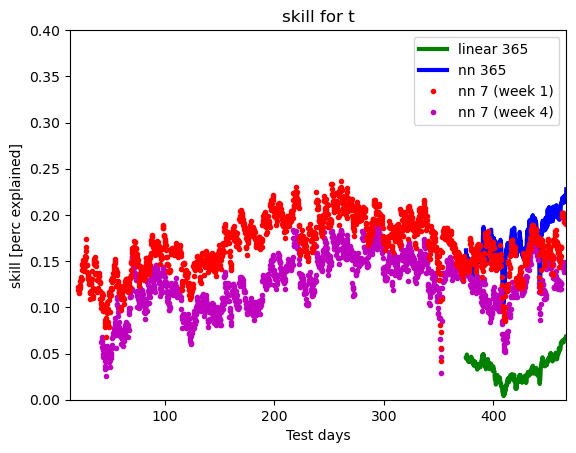

In [23]:
fig, ax = plt.subplots()
step=0
cmap = matplotlib.cm.get_cmap('Greys')
smooth=5

#for step in range(number_of_training_steps):
#    skill_tmp=np.copy(skills[step])
#    start=starting_step+(training_step_length*step)+0.25
#    idx_train=np.where( (ts>=start) & (ts<(start+training_step_length)) )
#    skill_tmp[idx_train] = np.NAN
#    ax.plot(ts, moveav(skill_tmp,smooth), color=cmap(step/number_of_training_steps),linewidth=0.5)

idx_test=np.where( (ts>=375) )
ax.plot(ts[idx_test], moveav(skill_linear[idx_test],smooth), color='g',linewidth=3, label='linear 365')
ax.plot(ts[idx_test], moveav(skill_nn365[idx_test],smooth), color='b',linewidth=3, label='nn 365')

for step in range(number_of_training_steps):
    start=starting_step+(training_step_length*step)+0.25
    idx_test=np.where( (ts>=start+training_step_length) & (ts<(start+training_step_length+7)) )
    if len(idx_test[0])>1:
        ax.plot(ts[idx_test], moveav(skills[step][idx_test],smooth), color='r',marker='.',linestyle='')
    
    idx_test=np.where( (ts>=start+training_step_length+21) & (ts<(start+training_step_length+28)) )
    if len(idx_test[0])>1:
        ax.plot(ts[idx_test], moveav(skills[step][idx_test],smooth), color='m',marker='.',linestyle='')
pass

ax.set_ylim(0,0.4)
#ax.set_xlim(375,max(ts))
ax.set_xlim(14,max(ts))
ax.legend(['linear 365','nn 365','nn 7 (week 1)','nn 7 (week 4)'])
ax.set_xlabel('Test days')
ax.set_ylabel('skill [perc explained]')
ax.set_title(f"skill for {varn}")


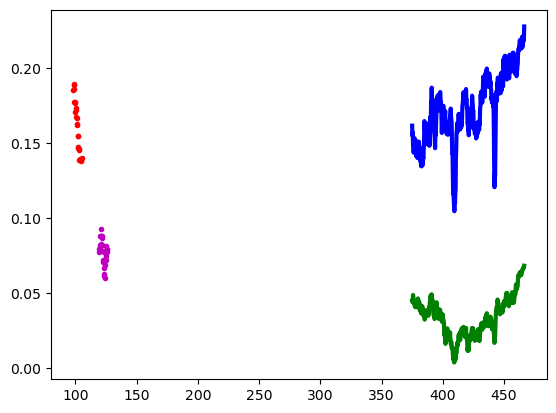

In [15]:
fig, ax = plt.subplots()
cmap = matplotlib.cm.get_cmap('Greys')
smooth=5

idx_test=np.where( (ts>=375) )
ax.plot(ts[idx_test], moveav(skill_linear[idx_test],smooth), color='g',linewidth=3, label='linear 365')
ax.plot(ts[idx_test], moveav(skill_nn365[idx_test],smooth), color='b',linewidth=3, label='nn 365')

start=starting_step+(training_step_length*step)+0.25
idx_test=np.where( (ts>=start+training_step_length) & (ts<(start+training_step_length+7)) )
ax.plot(ts[idx_test], moveav(skills[step][idx_test],smooth), color='r',marker='.',linestyle='')

idx_test=np.where( (ts>=start+training_step_length+21) & (ts<(start+training_step_length+28)) )
ax.plot(ts[idx_test], moveav(skills[step][idx_test],smooth), color='m',marker='.',linestyle='')